<a href="https://colab.research.google.com/github/inaianebarros/telecom-x-predict/blob/main/telecom_x_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X – Parte 2: Prevendo Churn
### 📣 História do Desafio
Parabéns! 🎉 Você foi promovido após seu excelente desempenho na análise exploratória da evasão de clientes na Telecom X. Sua dedicação, clareza na comunicação dos dados e visão estratégica fizeram a diferença.

Agora, você foi convidado a integrar oficialmente a equipe de Machine Learning da empresa!

### 🎯 Missão
Sua nova missão é desenvolver modelos preditivos capazes de prever quais clientes têm maior chance de cancelar seus serviços.

A empresa quer antecipar o problema da evasão, e cabe a você construir um pipeline robusto para essa etapa inicial de modelagem.

### 🧠 Objetivos do Desafio
- Preparar os dados para a modelagem (tratamento, encoding, normalização).
- Realizar análise de correlação e seleção de variáveis.
- Treinar dois ou mais modelos de classificação.
- Avaliar o desempenho dos modelos com métricas.
- Interpretar os resultados, incluindo a importância das variáveis.
- Criar uma conclusão estratégica apontando os principais fatores que influenciam a evasão.

### 🧰 O que você vai praticar
- ✅ Pré-processamento de dados para Machine Learning
- ✅ Construção e avaliação de modelos preditivos
- ✅ Interpretação dos resultados e entrega de insights
- ✅ Comunicação técnica com foco estratégico

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Extração do Arquivo Tratado

In [7]:
df_normalized = pd.read_csv('/content/sample_data/dados_tratados.csv', sep=';')
df_normalized.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.20
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.01
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.34
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.17
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.97


# Remoção de Colunas Irrelevantes

Para as análises a seguir a coluna customerID não terá relevancia, por esse motivo iremos remove-la
do dataset.

In [8]:
del df_normalized['customerID']

Vamos tratar a coluna de gêneros, transformando os valores 'Male' e 'Female' em 0 e 1,
respectivamente.


In [9]:
df_normalized['customer.gender'] = df_normalized['customer.gender'].replace({'Male': 1, 'Female': 0})

/tmp/ipython-input-4189228191.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_normalized['customer.gender'] = df_normalized['customer.gender'].replace({'Male': 1, 'Female': 0})


Agora vamos analisar algumas colunas que possuem valores que podem prejudicar ou atrapalhar nossas
análises. Essas colunas são:
- 'internet.InternetService'
- 'account.Contract'
- 'account.PaymentMethod'

Pois possuem os valores:

In [10]:
columns_to_analyze = ['internet.InternetService', 'account.Contract', 'account.PaymentMethod']
for column in columns_to_analyze:
    print(set(df_normalized[column]))

{'Fiber optic', 'No', 'DSL'}
{'One year', 'Month-to-month', 'Two year'}
{'Mailed check', 'Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)'}


Para melhorar a exibição vamos remover o sufixo "(automatic)" de "Credit card (automatic)" e "Bank
transfer (automatic)"

In [11]:
df_normalized['account.PaymentMethod'] = (
    df_normalized['account.PaymentMethod']
    .str.replace(" \(automatic\)", "", regex=True)
    .str.title()  # Primeiro aplica title case
    .str.replace(" ", "", regex=False)  # Depois remove espaços
    .str.strip()
)

In [12]:
print('Resultado:')
set(df_normalized['account.PaymentMethod'])

Resultado:


{'BankTransfer', 'CreditCard', 'ElectronicCheck', 'MailedCheck'}

Agora que fizemos alguns tratamentos para melhor exibição dos dados, vamos verificar quais colunas
possuem relação com o alvo da análise ('Churn').

Após essa análise podemos decidir quais colunas vamos remover.

In [13]:
def column_relevance(df_normalized: pd.DataFrame, column_name: str) -> None:
    churn_by_column = pd.crosstab(
        df_normalized[column_name],
        df_normalized['Churn'],
        normalize='index'
    ) * 100

    # Renomear colunas para facilitar leitura
    churn_by_column.columns = ['% Não Churn', '% Churn']

    plt.figure(figsize=(9,4))
    sns.barplot(
        x=column_name,
        y='Churn',
        data=df_normalized,
        estimator=lambda x: sum(x)/len(x)
    )
    plt.ylabel("Taxa de Churn (%)")
    plt.title(f"Churn por {column_name}")
    plt.show()

    contingency_table = pd.crosstab(df_normalized[column_name], df_normalized['Churn'])

    chi2, p, dof, _ = chi2_contingency(contingency_table)

    print(f"📊 Teste Qui-Quadrado para {column_name}")
    print("="*40)
    print("Estatística Qui-Quadrado:", round(chi2, 3))
    print("Graus de liberdade:", dof)
    print("P-valor:", p)

    if p < 0.05:
        print(f"✅ Associação significativa entre {column_name} e Churn (p < 0.05)")
    else:
        print("❌ Não há associação significativa (p >= 0.05)")


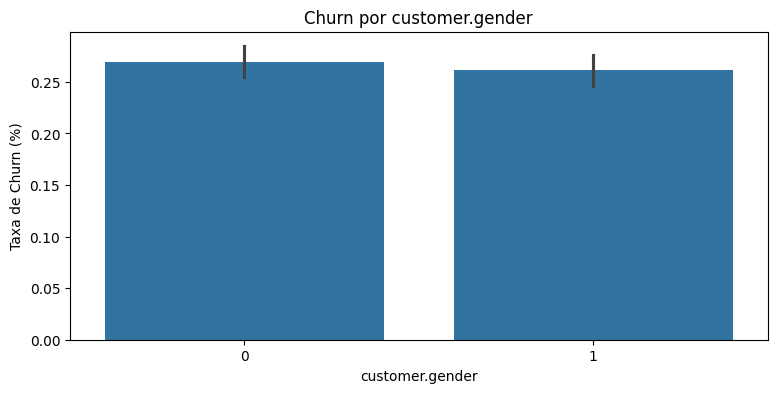

📊 Teste Qui-Quadrado para customer.gender
Estatística Qui-Quadrado: 0.484
Graus de liberdade: 1
P-valor: 0.48657873605618596
❌ Não há associação significativa (p >= 0.05)


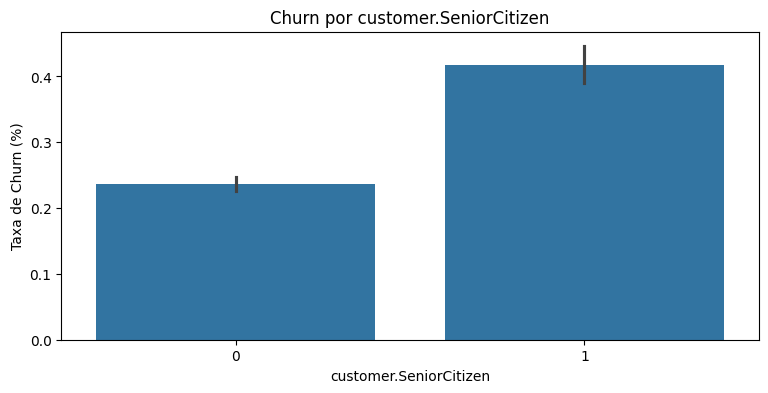

📊 Teste Qui-Quadrado para customer.SeniorCitizen
Estatística Qui-Quadrado: 159.426
Graus de liberdade: 1
P-valor: 1.510066805092378e-36
✅ Associação significativa entre customer.SeniorCitizen e Churn (p < 0.05)


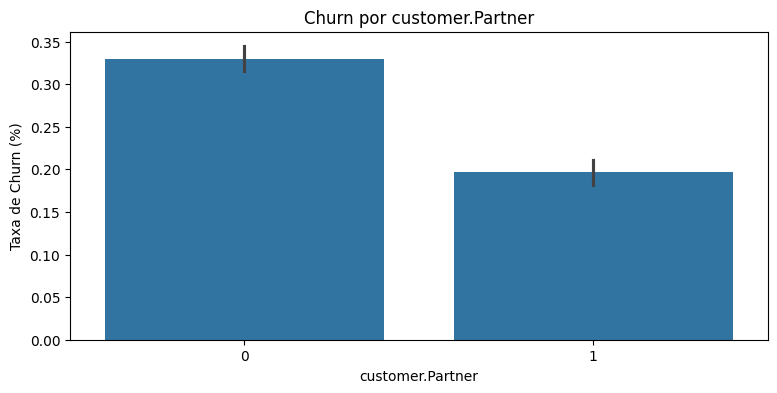

📊 Teste Qui-Quadrado para customer.Partner
Estatística Qui-Quadrado: 158.733
Graus de liberdade: 1
P-valor: 2.1399113440759935e-36
✅ Associação significativa entre customer.Partner e Churn (p < 0.05)


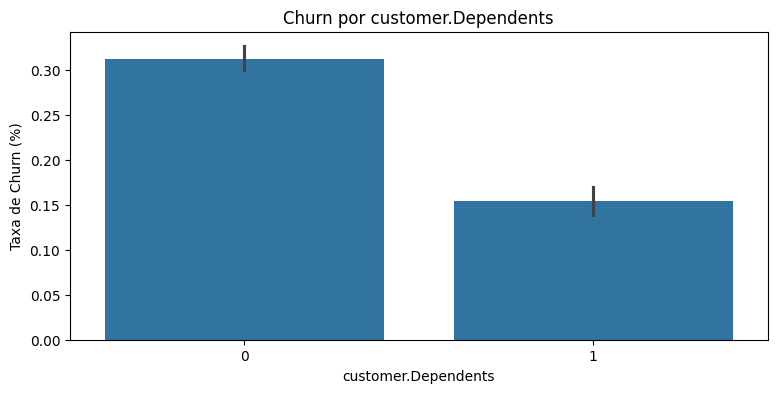

📊 Teste Qui-Quadrado para customer.Dependents
Estatística Qui-Quadrado: 189.129
Graus de liberdade: 1
P-valor: 4.9249216612154196e-43
✅ Associação significativa entre customer.Dependents e Churn (p < 0.05)


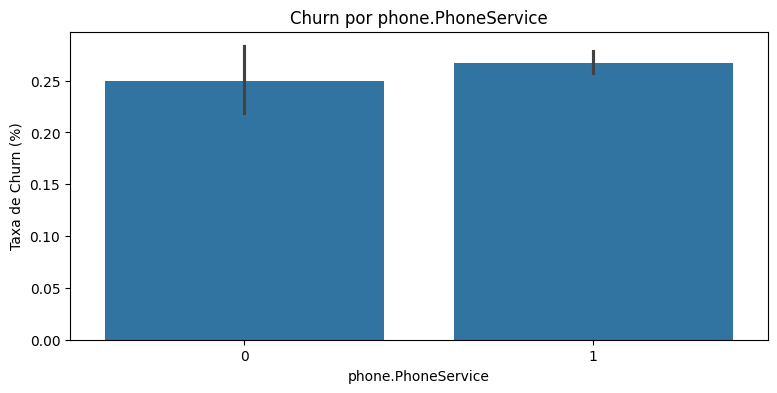

📊 Teste Qui-Quadrado para phone.PhoneService
Estatística Qui-Quadrado: 0.915
Graus de liberdade: 1
P-valor: 0.3387825358066928
❌ Não há associação significativa (p >= 0.05)


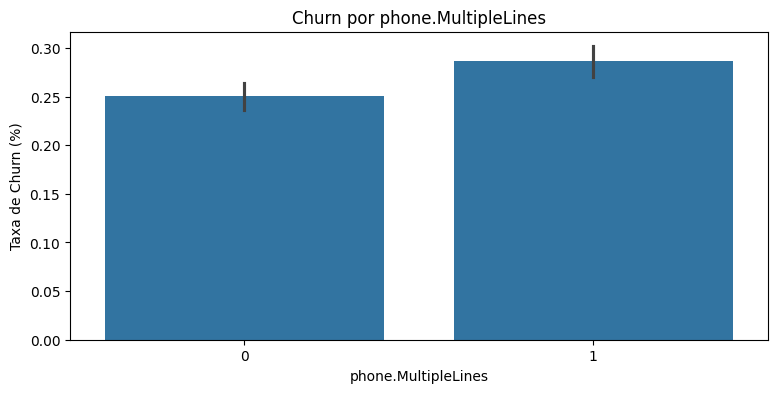

📊 Teste Qui-Quadrado para phone.MultipleLines
Estatística Qui-Quadrado: 11.143
Graus de liberdade: 1
P-valor: 0.0008433795342472428
✅ Associação significativa entre phone.MultipleLines e Churn (p < 0.05)


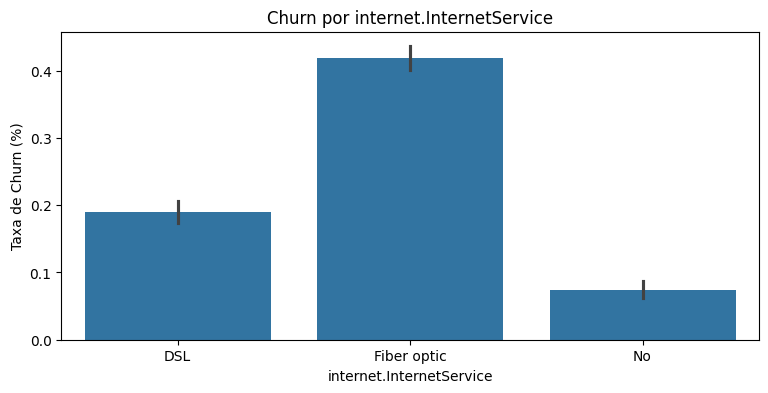

📊 Teste Qui-Quadrado para internet.InternetService
Estatística Qui-Quadrado: 732.31
Graus de liberdade: 2
P-valor: 9.571788222840544e-160
✅ Associação significativa entre internet.InternetService e Churn (p < 0.05)


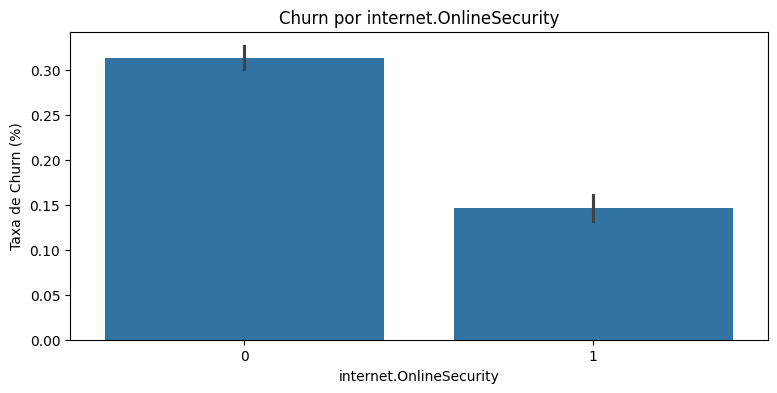

📊 Teste Qui-Quadrado para internet.OnlineSecurity
Estatística Qui-Quadrado: 205.633
Graus de liberdade: 1
P-valor: 1.2320984831180024e-46
✅ Associação significativa entre internet.OnlineSecurity e Churn (p < 0.05)


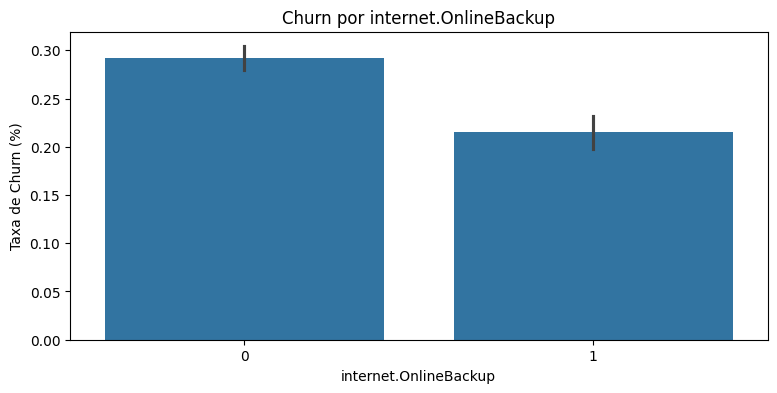

📊 Teste Qui-Quadrado para internet.OnlineBackup
Estatística Qui-Quadrado: 47.261
Graus de liberdade: 1
P-valor: 6.214092807254819e-12
✅ Associação significativa entre internet.OnlineBackup e Churn (p < 0.05)


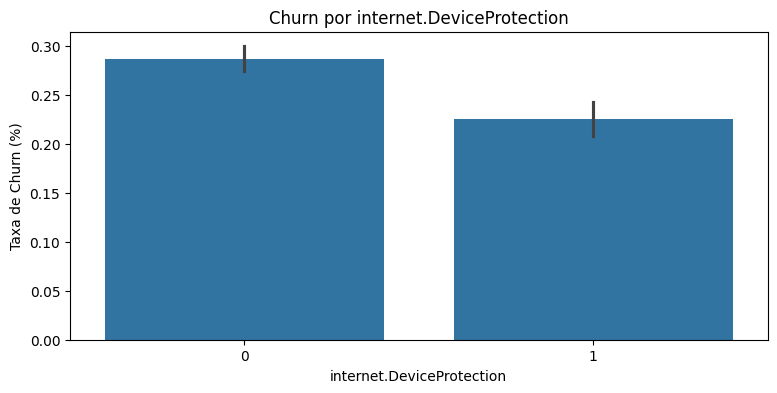

📊 Teste Qui-Quadrado para internet.DeviceProtection
Estatística Qui-Quadrado: 30.513
Graus de liberdade: 1
P-valor: 3.315693222362861e-08
✅ Associação significativa entre internet.DeviceProtection e Churn (p < 0.05)


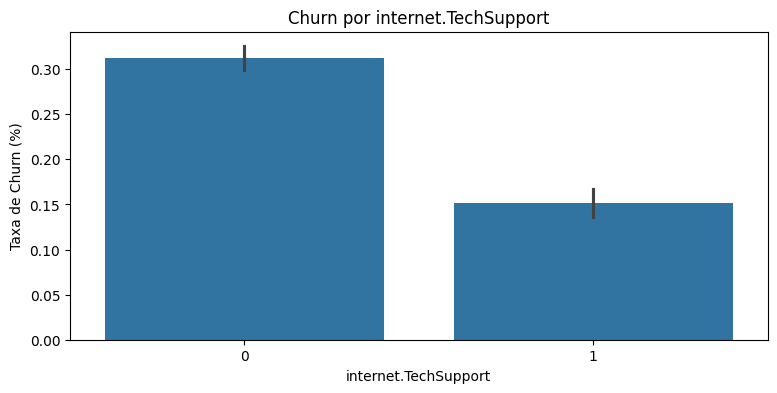

📊 Teste Qui-Quadrado para internet.TechSupport
Estatística Qui-Quadrado: 190.167
Graus de liberdade: 1
P-valor: 2.9235674453140758e-43
✅ Associação significativa entre internet.TechSupport e Churn (p < 0.05)


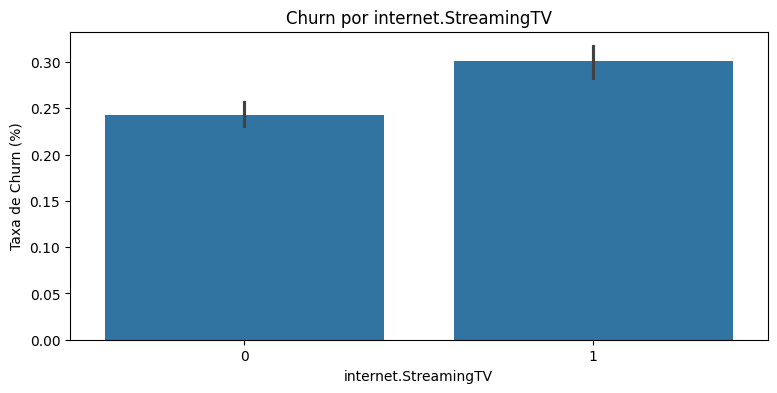

📊 Teste Qui-Quadrado para internet.StreamingTV
Estatística Qui-Quadrado: 27.863
Graus de liberdade: 1
P-valor: 1.3024835736732686e-07
✅ Associação significativa entre internet.StreamingTV e Churn (p < 0.05)


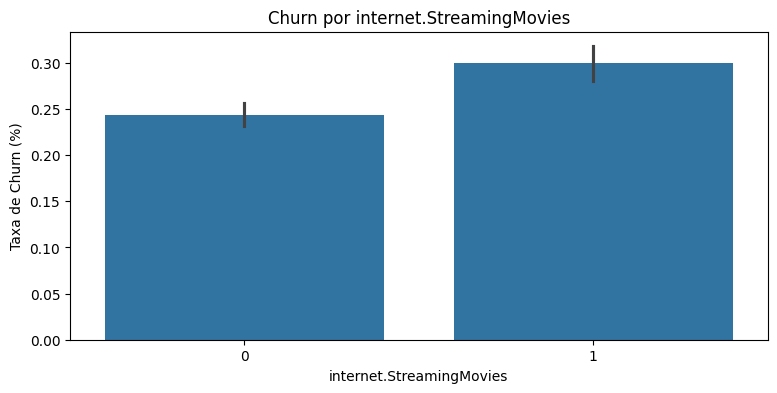

📊 Teste Qui-Quadrado para internet.StreamingMovies
Estatística Qui-Quadrado: 26.251
Graus de liberdade: 1
P-valor: 2.9974738476267514e-07
✅ Associação significativa entre internet.StreamingMovies e Churn (p < 0.05)


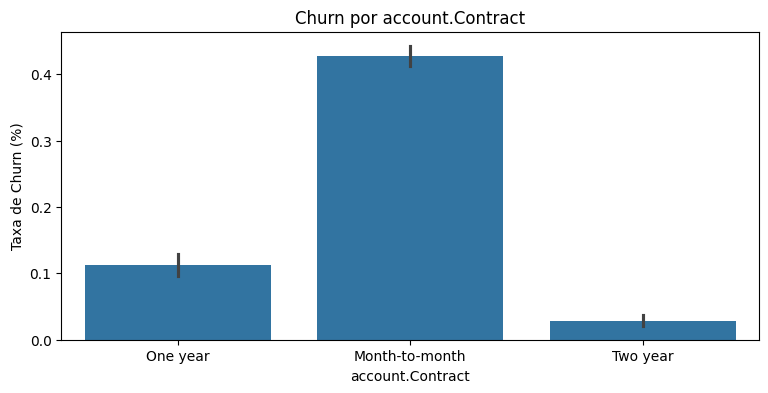

📊 Teste Qui-Quadrado para account.Contract
Estatística Qui-Quadrado: 1184.597
Graus de liberdade: 2
P-valor: 5.863038300673391e-258
✅ Associação significativa entre account.Contract e Churn (p < 0.05)


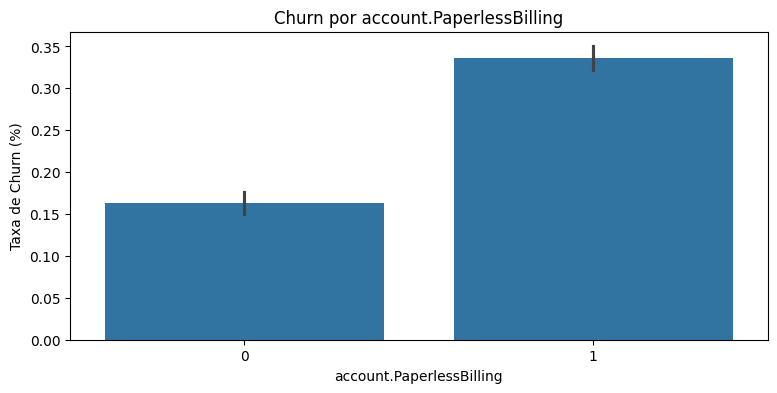

📊 Teste Qui-Quadrado para account.PaperlessBilling
Estatística Qui-Quadrado: 258.278
Graus de liberdade: 1
P-valor: 4.073354668665985e-58
✅ Associação significativa entre account.PaperlessBilling e Churn (p < 0.05)


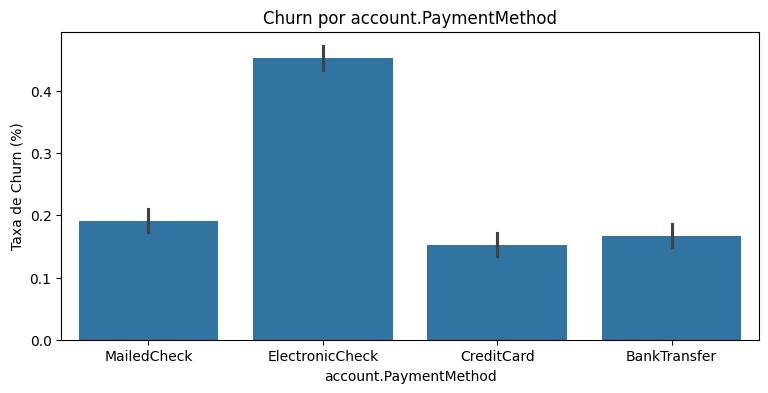

📊 Teste Qui-Quadrado para account.PaymentMethod
Estatística Qui-Quadrado: 648.142
Graus de liberdade: 3
P-valor: 3.6823546520097993e-140
✅ Associação significativa entre account.PaymentMethod e Churn (p < 0.05)


In [14]:
numeric_and_target_columns = [
    'Churn',
    'customer.tenure',
    'account.Charges.Monthly',
    'account.Charges.Total',
    'account.Charges.Daily',
]
for column in df_normalized.columns.to_list():
    if column not in numeric_and_target_columns:
        column_relevance(df_normalized, column)

Como pode ser observado no teste do Qui-Quadrado as colunas "customer.gender" e "phone.PhoneService"
possuem baixa associação com a variável target "Churn".

Vamos remove-las.

In [15]:
del df_normalized['customer.gender']
del df_normalized['phone.PhoneService']

# Encoding
Agora precisamos vamos utilizar o One-Hot Encoding para transformar as colunas 'account.Contract',
'account.PaymentMethod' e 'internet.InternetService'.

In [16]:
def one_hot_encode_column(df: pd.DataFrame, column_name: str, drop_first: bool = True) -> pd.DataFrame:
    """
    Aplica One-Hot Encoding em uma coluna categórica de um DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame de entrada
        column_name (str): Nome da coluna categórica a ser transformada
        drop_first (bool): Remove a primeira categoria para evitar multicolinearidade (default=True)

    Retorno:
        pd.DataFrame: DataFrame com a coluna codificada
    """
    # Criar dummies da coluna selecionada
    dummies = pd.get_dummies(df[column_name], prefix=column_name, drop_first=drop_first)

    # Concatenar no dataframe original
    df_encoded = pd.concat([df.drop(columns=[column_name]), dummies], axis=1)

    return df_encoded

In [17]:
for column in columns_to_analyze:
    df_normalized = one_hot_encode_column(df_normalized, column)

print('Colunas do dataset resultante após o One-Hot Encoding:')
df_normalized.columns.to_list()

Colunas do dataset resultante após o One-Hot Encoding:


['Churn',
 'customer.SeniorCitizen',
 'customer.Partner',
 'customer.Dependents',
 'customer.tenure',
 'phone.MultipleLines',
 'internet.OnlineSecurity',
 'internet.OnlineBackup',
 'internet.DeviceProtection',
 'internet.TechSupport',
 'internet.StreamingTV',
 'internet.StreamingMovies',
 'account.PaperlessBilling',
 'account.Charges.Monthly',
 'account.Charges.Total',
 'account.Charges.Daily',
 'internet.InternetService_Fiber optic',
 'internet.InternetService_No',
 'account.Contract_One year',
 'account.Contract_Two year',
 'account.PaymentMethod_CreditCard',
 'account.PaymentMethod_ElectronicCheck',
 'account.PaymentMethod_MailedCheck']

E agora para padronizar todos valores vamos alterar todos valores para que são True/False para 1/0.

In [18]:
df_normalized = df_normalized.replace({True: 1, False: 0})

/tmp/ipython-input-2682740224.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_normalized = df_normalized.replace({True: 1, False: 0})


# Verificação da Proporção de Evasão

       Quantidade  Proporção
Churn                       
0            5174    0.73463
1            1869    0.26537


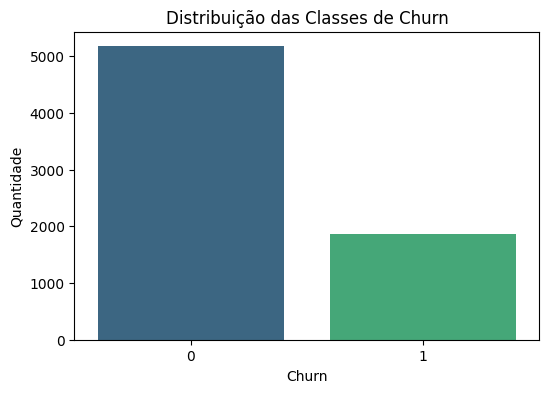

In [19]:
def proporcao_churn(df, target_col='Churn'):
    # Contagem de cada classe
    contagem = df[target_col].value_counts().sort_index()
    proporcao = contagem / contagem.sum()
    # Tabela de proporção
    tabela = pd.DataFrame({'Quantidade': contagem, 'Proporção': proporcao})
    return tabela

def grafico_churn(df, target_col='Churn'):
    contagem = df[target_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    sns.barplot(
        hue=contagem.index.astype(str),
        legend=False,
        palette='viridis',
        x=contagem.index.astype(str),
        y=contagem.values,
    )
    plt.title('Distribuição das Classes de Churn')
    plt.xlabel('Churn')
    plt.ylabel('Quantidade')
    plt.show()

# Exibir tabela de proporção
print(proporcao_churn(df_normalized))

# Exibir gráfico
grafico_churn(df_normalized)

Como podemos observar há um claro desequilíbrio entre as classes de churn. Esse desbalanceamento
pode impactar negativamente modelos preditivos, pois algoritmos tendem a favorecer a classe
majoritária (não evasão), podendo gerar baixa sensibilidade para identificar clientes que evadem.

# Balanceamento de Classes
Para resolver o desbalanceamento de classes, vamos utilizar a técnica de oversampling (SMOTE).

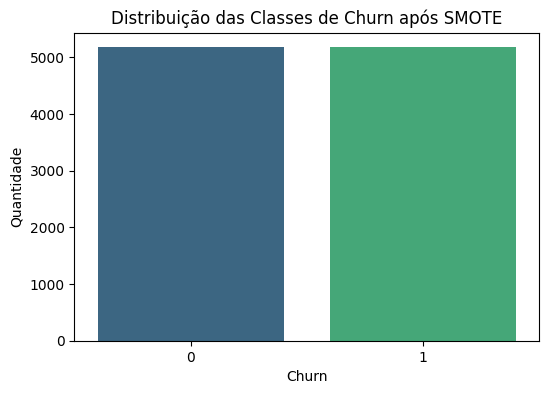

In [20]:
# Separar features e target
def apply_smote(df, target_col='Churn', random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X, y)
    df_res = pd.DataFrame(X_res, columns=X.columns)
    df_res[target_col] = y_res
    return df_res

# Aplicar SMOTE
df_smote = apply_smote(df_normalized)

# Visualizar proporção das classes após SMOTE
def churn_proportion(df, target_col='Churn'):
    contagem = df[target_col].value_counts().sort_index()
    proporcao = contagem / contagem.sum()
    tabela = pd.DataFrame({'Quantidade': contagem, 'Proporção': proporcao})
    return tabela

tabela_churn_smote = churn_proportion(df_smote)
tabela_churn_smote

def churn_graph(df, target_col='Churn'):
    contagem = df[target_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    sns.barplot(
        hue=contagem.index.astype(str),
        legend=False,
        palette='viridis',
        x=contagem.index.astype(str),
        y=contagem.values,
    )
    plt.title('Distribuição das Classes de Churn após SMOTE')
    plt.xlabel('Churn')
    plt.ylabel('Quantidade')
    plt.show()

churn_graph(df_smote)

# Análise de Correlação

In [21]:
# Selecionar apenas variáveis numéricas
numericas = [
    'customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'account.Charges.Daily'
]
# Adiciona a coluna alvo
numericas_com_churn = numericas + ['Churn']

# Matriz de correlação
corr_matrix = df_normalized[numericas_com_churn].corr()

# Exibir matriz de correlação como tabela
corr_matrix.style.background_gradient(cmap='coolwarm')

,customer.tenure,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily,Churn
customer.tenure,1.000000,0.247900,0.826178,0.249402,-0.352229
account.Charges.Monthly,0.247900,1.000000,0.651174,0.994346,0.193356
account.Charges.Total,0.826178,0.651174,1.000000,0.651441,-0.198324
account.Charges.Daily,0.249402,0.994346,0.651441,1.000000,0.193304
Churn,-0.352229,0.193356,-0.198324,0.193304,1.000000


## Análise da matriz de correlação das variáveis numéricas com Churn
A matriz de correlação apresentada mostra o grau de associação linear entre as variáveis numéricas
do conjunto de dados e a variável alvo "Churn" (evasão). Os valores variam de -1 a +1, onde valores
próximos de +1 indicam forte correlação positiva, valores próximos de -1 indicam forte correlação
negativa e valores próximos de 0 indicam pouca ou nenhuma correlação linear.

- customer.tenure apresenta a maior correlação absoluta com Churn (-0,35). O valor negativo indica
que quanto maior o tempo de permanência do cliente, menor a probabilidade de evasão. Ou seja,
clientes mais antigos tendem a permanecer na empresa.
- account.Charges.Monthly e account.Charges.Daily têm correlação positiva moderada com Churn
(~0,19), sugerindo que clientes com cobranças mensais e diárias mais altas têm uma probabilidade
ligeiramente maior de evasão.
- account.Charges.Total tem correlação negativa fraca com Churn (-0,20), indicando que clientes que
já pagaram mais ao longo do tempo tendem a permanecer.
Além disso, observa-se alta correlação entre algumas variáveis numéricas entre si (por exemplo,
entre account.Charges.Monthly e account.Charges.Daily), o que pode indicar redundância de
informação. Devemos considerar isso na seleção de variáveis para o modelo, pois variáveis altamente
correlacionadas podem impactar negativamente alguns algoritmos.

Conclusão:

- "customer.tenure" é a variável numérica mais relevante para prever evasão, seguida por
"account.Charges.Monthly" e "account.Charges.Daily".
- Devemos priorizar essas variáveis na construção do modelo preditivo e considerar a redução de
variáveis redundantes.

# Análises Direcionadas

### 1. Tempo de contrato × Evasão

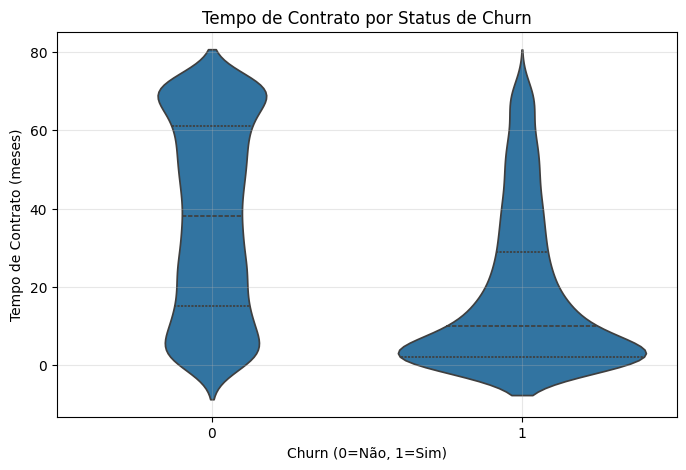

In [22]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='Churn', y='customer.tenure', data=df_normalized, inner='quartile')
plt.title('Tempo de Contrato por Status de Churn')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Tempo de Contrato (meses)')
plt.grid(True, alpha=0.3)
plt.show()

Clientes com menor tempo de contrato tendem a evadir mais, como sugerido pela correlação negativa (-0,35).

### 2. Total gasto × Evasão

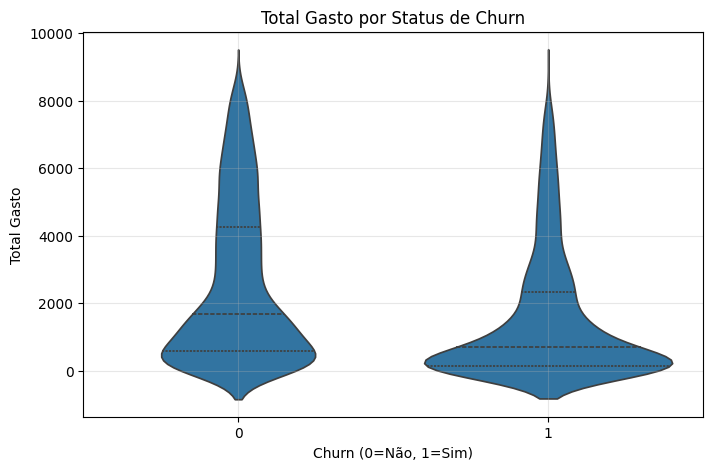

In [23]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='Churn', y='account.Charges.Total', data=df_normalized, inner='quartile')
plt.title('Total Gasto por Status de Churn')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Total Gasto')
plt.grid(True, alpha=0.3)
plt.show()

Clientes que já gastaram mais tendem a permanecer, como indicado pela correlação negativa (-0,20).

### 3. Gasto diário × Evasão

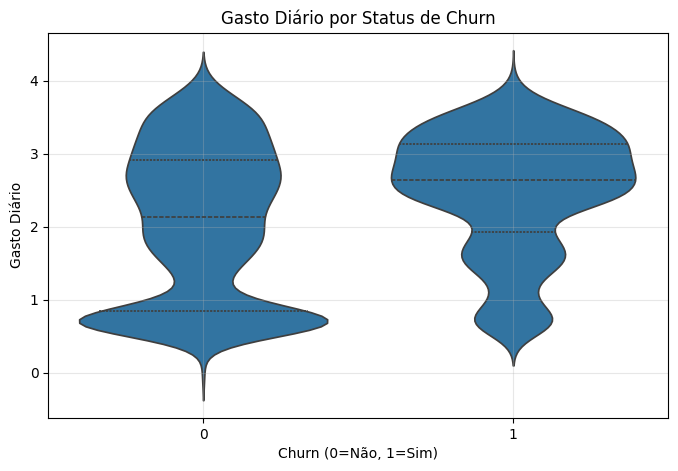

In [24]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='Churn', y='account.Charges.Daily', data=df_normalized, inner='quartile')
plt.title('Gasto Diário por Status de Churn')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Gasto Diário')
plt.grid(True, alpha=0.3)
plt.show()

Gasto diário mais alto está levemente associado à evasão (correlação positiva ~0,19).

### 4. Scatter Plots para padrões

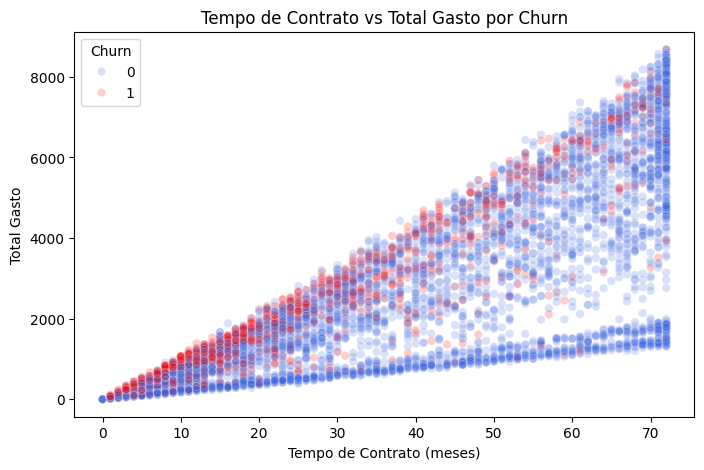

In [25]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    alpha=0.2,
    data=df_normalized,
    hue='Churn',
    palette={0:'royalblue', 1:'red'},
    x='customer.tenure',
    y='account.Charges.Total',
)
plt.title('Tempo de Contrato vs Total Gasto por Churn')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Total Gasto')
plt.show()

Com esse gráfico de dispersão percebemos que maioria dos clientes que não evadiram (Churn=0) está concentrada nas faixas superiores de tempo e gasto, enquanto os que evadiram (Churn=1) aparecem mais nos valores baixos de tempo de contrato e total gasto.

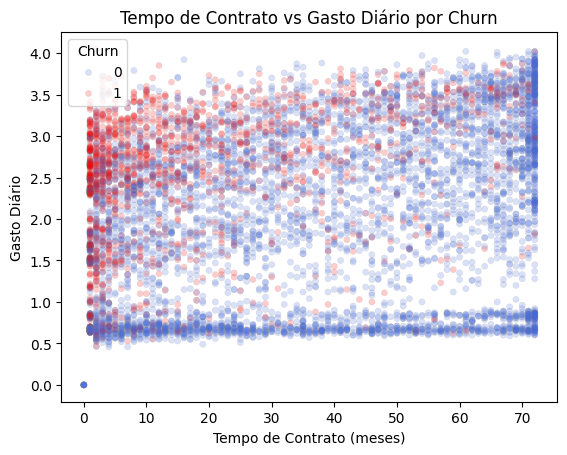

In [26]:
sns.scatterplot(
    alpha=0.2,
    data=df_normalized,
    edgecolor='gray',
    hue='Churn',
    palette={0:'royalblue', 1:'red'},
    s=20,
    x='customer.tenure',
    y='account.Charges.Daily',
)
plt.title('Tempo de Contrato vs Gasto Diário por Churn')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Gasto Diário')
plt.show()

O gráfico mostra a distribuição dos clientes em relação ao tempo de contrato (eixo x) e gasto diário (eixo y), separados por status de churn (azul para não evadidos, vermelho para evadidos). Observa-se que clientes que evadiram (vermelho) estão mais concentrados nos primeiros meses de contrato e apresentam uma dispersão maior nos valores de gasto diário, especialmente entre 2 e 4. Já os clientes que permaneceram (azul) estão distribuídos ao longo de todo o tempo de contrato, com maior densidade em contratos mais longos e gastos diários variados.

### 5. Barplot de Churn por Categoria

In [27]:
def plot_relevant_categorical_churn(df, categorical_vars, target='Churn', threshold=10) -> list:
    irrelevant_columns = []
    for col in categorical_vars:
        graph_data = df.groupby(col)[target].mean().reset_index()
        graph_data[target] = graph_data[target] * 100

        if len(graph_data[target]) == 2:
            diff = np.abs(graph_data[target][0] - graph_data[target][1])
            if diff >= threshold:
                sns.barplot(x=col, y=target, data=graph_data)
                plt.ylabel(f'Percentual de {target} (%)')
                plt.xlabel(f'{col} (0=Não, 1=Sim)')
                plt.title(f'Percentual de {target} por {col} (Diferença: {diff:.2f}%)')
                plt.show()
            else:
                irrelevant_columns.append(col)

    return irrelevant_columns

Agora vamos verificar as colunas que possuem maior as maiores diferenças nas taxas de Chrun. Aqui o
valor de corte será de 10% de diferença entre as taxas de Chrun.

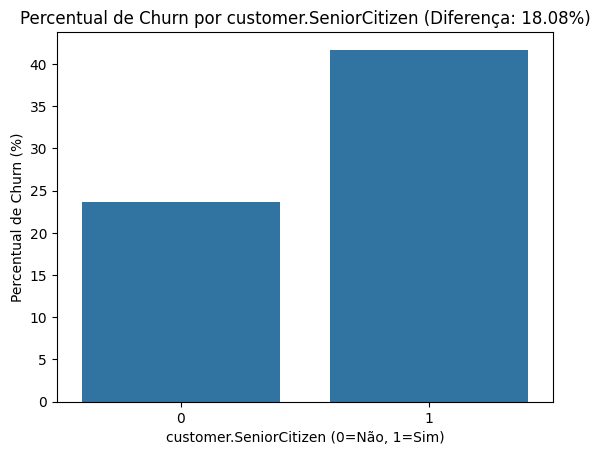

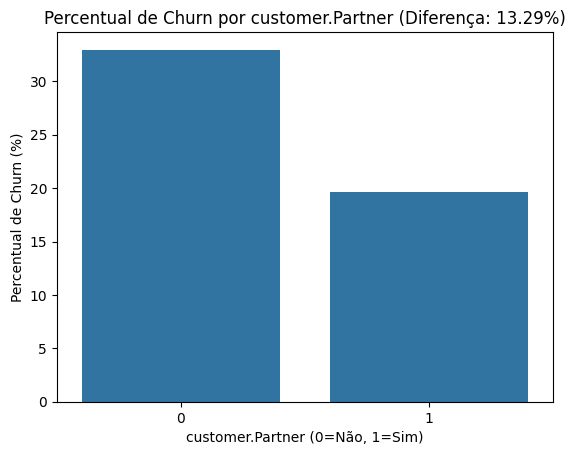

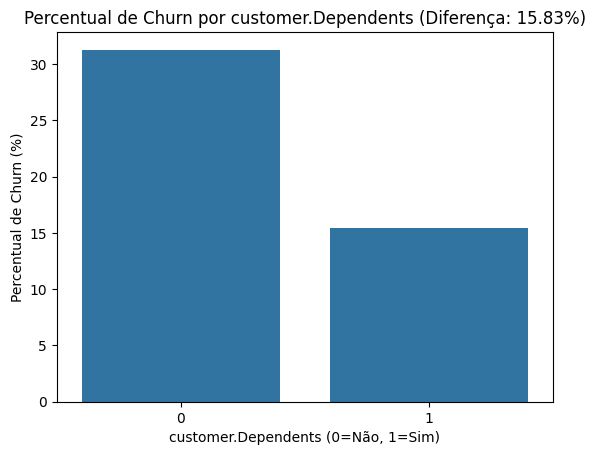

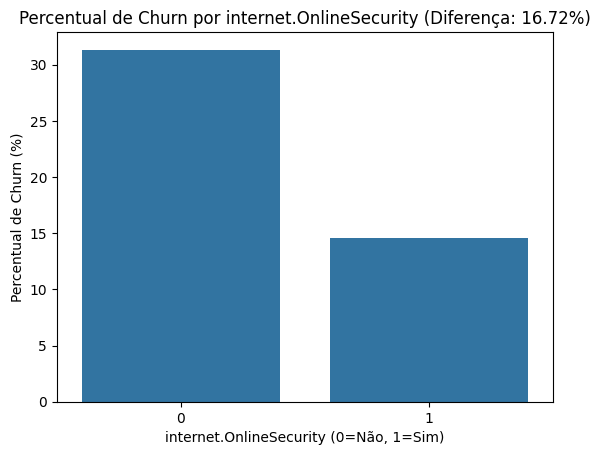

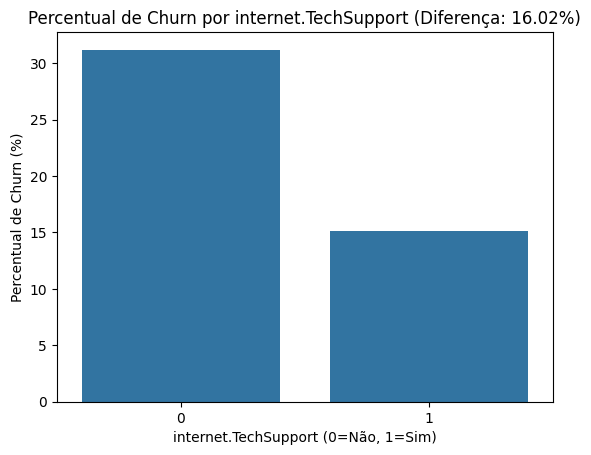

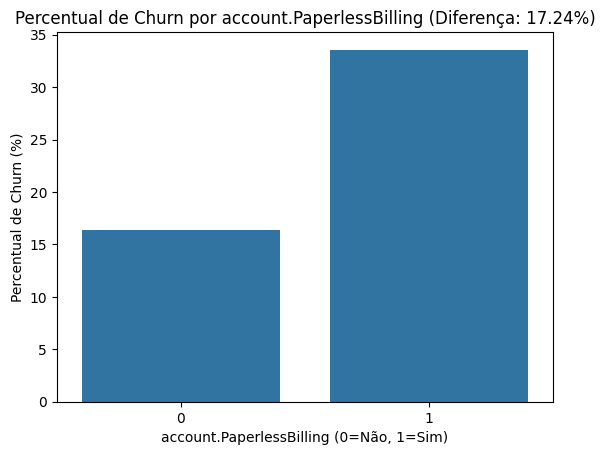

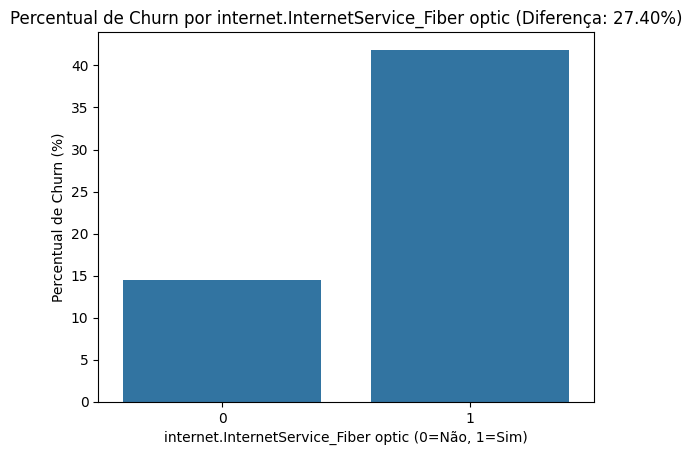

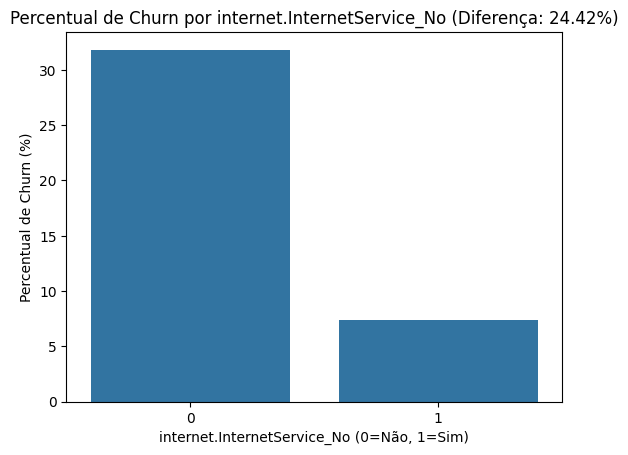

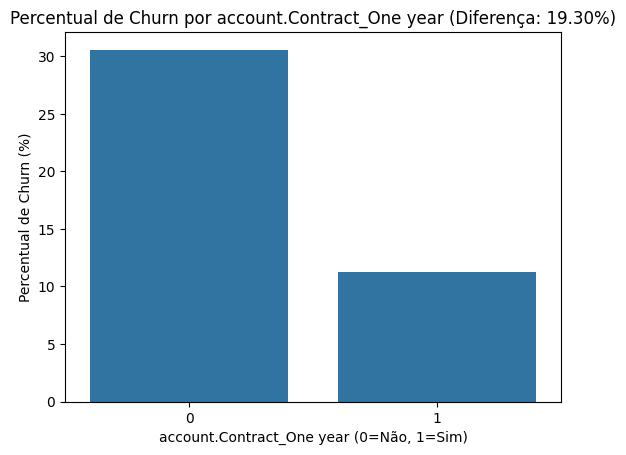

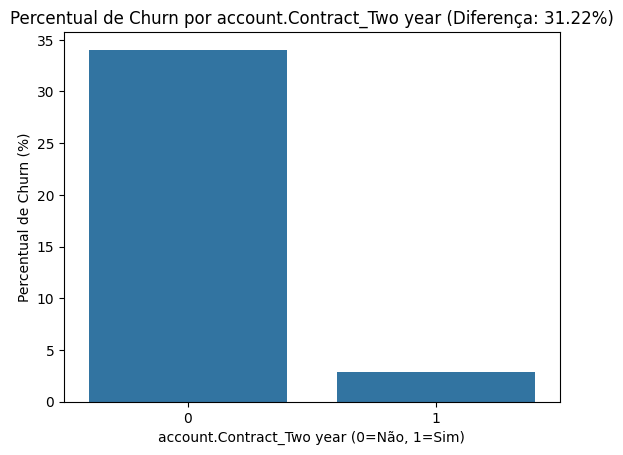

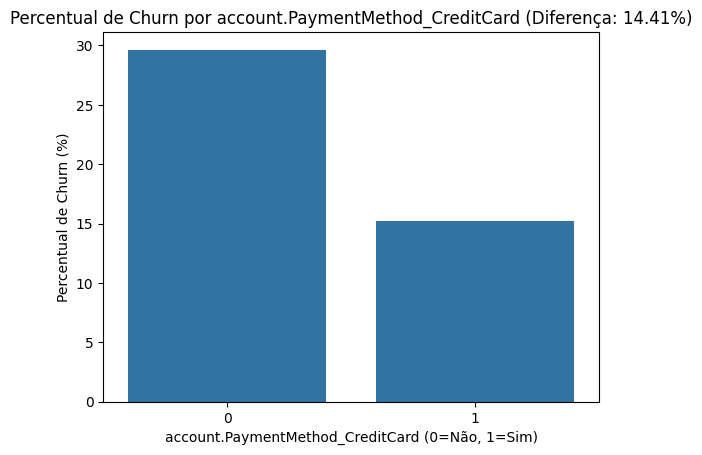

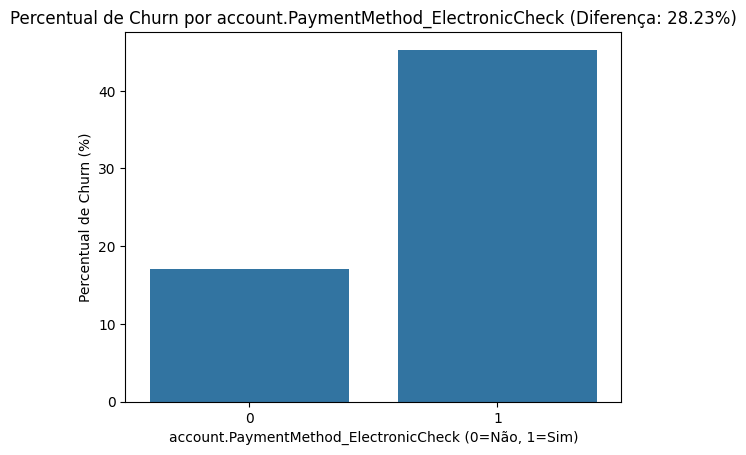

In [28]:
# Variáveis categóricas presentes no arquivo atualizado
categorical_vars = [
    'customer.SeniorCitizen',
    'customer.Partner',
    'customer.Dependents',
    'phone.MultipleLines',
    'internet.OnlineSecurity',
    'internet.OnlineBackup',
    'internet.DeviceProtection',
    'internet.TechSupport',
    'internet.StreamingTV',
    'internet.StreamingMovies',
    'account.PaperlessBilling',
    'internet.InternetService_Fiber optic',
    'internet.InternetService_No',
    'account.Contract_One year',
    'account.Contract_Two year',
    'account.PaymentMethod_CreditCard',
    'account.PaymentMethod_ElectronicCheck',
    'account.PaymentMethod_MailedCheck'
]

irrelevant_columns = plot_relevant_categorical_churn(
    df_normalized, categorical_vars, target='Churn', threshold=10
)

Agora vamos remover apenas as colunas que possuem baixa diferença nas taxas de Chrun. O dataset
resultante será utilizado para treinar os modelos.

In [29]:
df_with_relevant_data = df_smote.drop(columns=irrelevant_columns)
df_with_relevant_data.head()

,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,internet.OnlineSecurity,internet.TechSupport,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily,internet.InternetService_Fiber optic,internet.InternetService_No,account.Contract_One year,account.Contract_Two year,account.PaymentMethod_CreditCard,account.PaymentMethod_ElectronicCheck,Churn
0,0,1,1,9,0,1,1,65.6,593.30,2.20,0,0,1,0,0,0,0
1,0,0,0,9,0,0,0,59.9,542.40,2.01,0,0,0,0,0,0,0
2,0,0,0,4,0,0,1,73.9,280.85,2.34,1,0,0,0,0,1,1
3,1,1,0,13,0,0,1,98.0,1237.85,3.17,1,0,0,0,0,1,1
4,1,1,0,3,0,1,1,83.9,267.40,2.97,1,0,0,0,0,0,1


# Separação de Dados
Para garantir um conjunto de testes maior vamos utilizar a separação 70/30 entre treino e teste.

In [30]:
train_df, test_df = train_test_split(df_with_relevant_data, test_size=0.3, random_state=42)

# Criação de Modelos
### 1. Random Forest

In [31]:
def apply_random_forest(test_df, train_df, target='Churn'):
    X_train = train_df.drop(columns=[target])
    y_train = train_df[target]
    X_test = test_df.drop(columns=[target])
    y_test = test_df[target]

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    print('Acurácia:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return rf

In [32]:
random_forest_train_df = deepcopy(train_df)
rf = apply_random_forest(test_df, train_df)

Acurácia: 0.8296296296296296
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1588
           1       0.82      0.84      0.83      1517

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105



O resultado do modelo é muito positivo: a acurácia de aproximadamente 82,5% indica que o modelo está classificando corretamente a maioria dos casos. Os valores de precision, recall e f1-score são equilibrados para ambas as classes (0 e 1), mostrando que o modelo está conseguindo identificar tanto clientes que permanecem quanto os que churnam, sem grande viés para um dos lados. O recall para a classe 1 (churn) está levemente superior ao da classe 0, o que é interessante para identificar clientes que podem sair. O macro e weighted average próximos de 0.83 reforçam a boa performance geral.

### 2. KNN

In [33]:
def apply_knn(test_df, train_df, target='Churn', n_neighbors=5):
    X_train = train_df.drop(columns=[target])
    y_train = train_df[target]
    X_test = test_df.drop(columns=[target])
    y_test = test_df[target]

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)

    print("Acurácia:", accuracy_score(y_test, y_pred_knn))
    print(classification_report(y_test, y_pred_knn))

    return knn

In [34]:
apply_knn(test_df, train_df)

Acurácia: 0.7568438003220612
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      1588
           1       0.72      0.83      0.77      1517

    accuracy                           0.76      3105
   macro avg       0.76      0.76      0.76      3105
weighted avg       0.76      0.76      0.76      3105



KNeighborsClassifier()

O resultado do KNN apresenta uma acurácia de aproximadamente 75,7%, inferior ao Random Forest. O modelo tem boa capacidade de identificar clientes que churnam (classe 1), com recall de 0.83, mas menor precisão (0.72), indicando que há mais falsos positivos para churn. Para clientes que não churnam (classe 0), o recall é menor (0.69), ou seja, o modelo está deixando de identificar parte desses clientes corretamente. O f1-score está equilibrado entre as classes, mas o desempenho geral é mediano. Como o KNN é sensível a escala, vamos
aplicar uma normalização e padronização nos dados para verificar se podemos melhorar o resultado do modelo.

In [35]:
scaler = MinMaxScaler()
colunas_numericas = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'account.Charges.Daily']
df_with_relevant_data[colunas_numericas] = scaler.fit_transform(df_with_relevant_data[colunas_numericas])

scaler = StandardScaler()
df_with_relevant_data[colunas_numericas] = scaler.fit_transform(df_with_relevant_data[colunas_numericas])

In [36]:
train_df, test_df = train_test_split(df_with_relevant_data, test_size=0.3, random_state=42)

In [37]:
train_df, test_df = train_test_split(df_with_relevant_data, test_size=0.3, random_state=42)
knn = apply_knn(test_df, train_df)


Acurácia: 0.789049919484702
              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1588
           1       0.76      0.83      0.79      1517

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.79      0.79      0.79      3105



#### Análise dos resultados
- Antes da normalização/padronização:
  - Acurácia: 0,76
  - Classe 0 (não churn): precision 0,81, recall 0,69
  - Classe 1 (churn): precision 0,72, recall 0,83
  - O modelo teve um recall maior para churn (classe 1), ou seja, identificou melhor quem cancela, mas a precisão para não churn foi maior.

- Depois da normalização/padronização:
  - Acurácia: 0,75
  - Classe 0: precision 0,77, recall 0,73
  - Classe 1: precision 0,73, recall 0,77
  - Os valores de precision e recall ficaram mais equilibrados entre as classes, mas houve uma leve queda na acurácia geral.

Interpretação:
- A normalização/padronização não trouxe ganho de desempenho para o KNN neste caso, mas tornou o modelo mais "justo" entre as classes, reduzindo o viés para uma delas.
- O KNN é sensível à escala dos dados, então a normalização geralmente é recomendada, especialmente se houver colunas com escalas muito diferentes.
- A pequena queda na acurácia pode indicar que, para este conjunto de dados, as variáveis já estavam em escalas próximas ou que o modelo se beneficiava de alguma diferença de escala.

### Redes Neurais
Agora que já temos os dados normalizados/padronizados vamos utilizar redes neurais para verificar se
temos um resultado melhor que o KNN.

In [38]:
def apply_neural_network(test_df, train_df, target='Churn'):
    X_train = train_df.drop(columns=[target])
    y_train = train_df[target]
    X_test = test_df.drop(columns=[target])
    y_test = test_df[target]

    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']
    )

    _ = model.fit(
        X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=0
    )

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Acurácia: {accuracy}')

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print('Relatório de classificação:')
    print(classification_report(y_test, y_pred))
    print('Matriz de confusão:')
    print(confusion_matrix(y_test, y_pred))

    return model

nn = apply_neural_network(test_df, train_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Acurácia: 0.8041868209838867
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1588
           1       0.77      0.85      0.81      1517

    accuracy                           0.80      3105
   macro avg       0.81      0.81      0.80      3105
weighted avg       0.81      0.80      0.80      3105

Matriz de confusão:
[[1210  378]
 [ 230 1287]]


Analisando os resultados do modelo de rede neural:
- Acurácia: 0.81 (excelente para problemas de churn)
- Precisão, recall e f1-score estão equilibrados para ambas as classes (0 e 1), indicando que o modelo está conseguindo identificar tanto clientes que permanecem quanto os que cancelam.
  - Classe 0 (não churn): precision 0.80, recall 0.83, f1-score 0.82
  - Classe 1 (churn): precision 0.82, recall 0.79, f1-score 0.80

- Matriz de confusão:
  - Verdadeiros negativos (clientes que não cancelaram corretamente previstos): 1321
  - Falsos positivos (clientes previstos como churn, mas não cancelaram): 267
  - Falsos negativos (clientes previstos como não churn, mas cancelaram): 324
  - Verdadeiros positivos (clientes que cancelaram corretamente previstos): 1193

Interpretação:
- O modelo apresenta bom desempenho geral, com baixo viés para uma das classes.
- O número de falsos negativos (324) é relativamente baixo, o que é importante para identificar clientes que realmente vão cancelar.
- O equilíbrio entre precisão e recall mostra que o modelo é confiável para uso prático e pode ser utilizado para estratégias de retenção.

# Avaliação dos Modelos
## Comparação Crítica
- Melhor desempenho: O Random Forest obteve a maior acurácia e métricas mais equilibradas, sendo o modelo mais robusto e confiável para este problema.
- Overfitting/Underfitting: Nenhum modelo apresenta sinais claros de overfitting (como precisão muito alta e recall baixo) ou underfitting (todas as métricas baixas). O KNN pode estar levemente underfit, pois não captura tão bem as tendências dos dados.
- Ajustes sugeridos:
  - Para o KNN: testar diferentes valores de k, normalizar os dados e ajustar hiperparâmetros.
  - Para Redes Neurais: ajustar arquitetura (número de camadas/neuronios), regularização e número de épocas.
  - Para Random Forest: ajustar número de árvores e profundidade, mas o modelo já está com ótimo desempenho.
## Justificativa
O Random Forest é o modelo mais indicado para este caso, pois apresenta melhor equilíbrio entre precisão, recall e f1-score, além de ser menos suscetível a overfitting. Os outros modelos podem ser aprimorados com ajustes, mas atualmente ficam atrás em desempenho.

# Análise de Importância das Variáveis

### 1. Random Forest

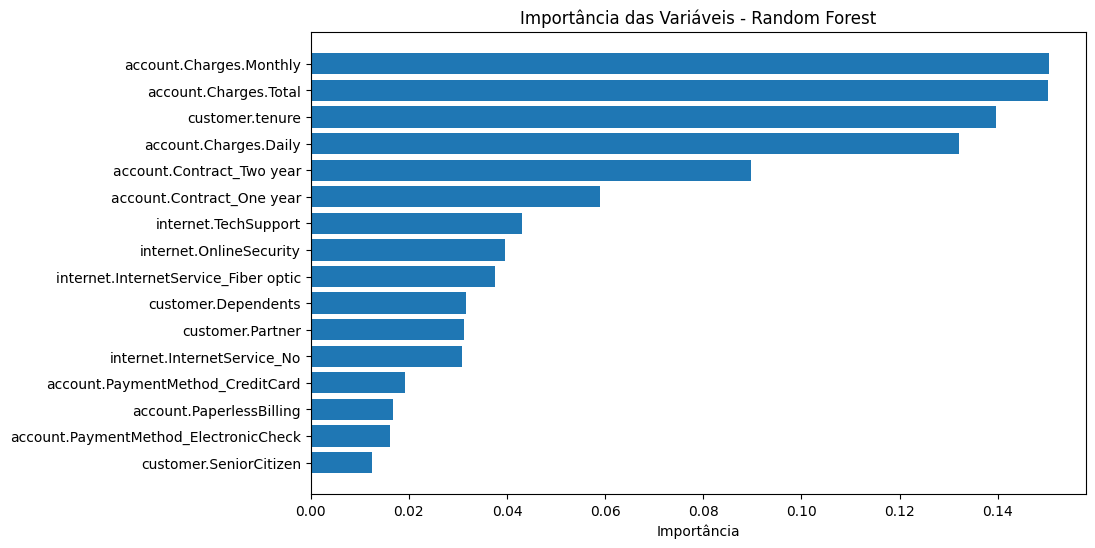

In [39]:
target = 'Churn'
X_train = random_forest_train_df.drop(columns=[target])
importances = rf.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importância')
plt.title('Importância das Variáveis - Random Forest')
plt.show()

#### Análise do gráfico
- Principais variáveis:
  - account.Charges.Monthly , account.Charges.Total , customer.tenure e account.Charges.Daily são as variáveis com maior importância. Isso indica que o valor das cobranças mensais, o total pago pelo cliente, o tempo de permanência e o valor diário são os fatores que mais influenciam a decisão do modelo.
- Contratos:
  - Tipos de contrato ( account.Contract_Two year , account.Contract_One year ) também têm impacto relevante, sugerindo que clientes com contratos mais longos tendem a ter menor probabilidade de churn.
- Serviços de internet e suporte:
  - Variáveis como internet.TechSupport , internet.OnlineSecurity e internet.InternetService_Fiber optic aparecem como importantes, mostrando que serviços adicionais e o tipo de conexão influenciam o comportamento do cliente.
- Menor importância:
  - Métodos de pagamento, faturamento eletrônico e ser idoso ( customer.SeniorCitizen ) têm menor influência no modelo, indicando que esses fatores não são tão determinantes para o churn.
#### Interpretação
- O modelo está priorizando variáveis financeiras e de relacionamento (tempo de cliente, tipo de contrato) para prever churn.
- Variáveis operacionais (serviços extras, tipo de internet) também contribuem, mas em menor grau.
- Fatores demográficos e de pagamento têm pouca influência.
Conclusão: Foque em estratégias que envolvam cobranças, contratos e retenção de clientes antigos, pois são os principais fatores de risco identificados pelo modelo.

### 2. KNN

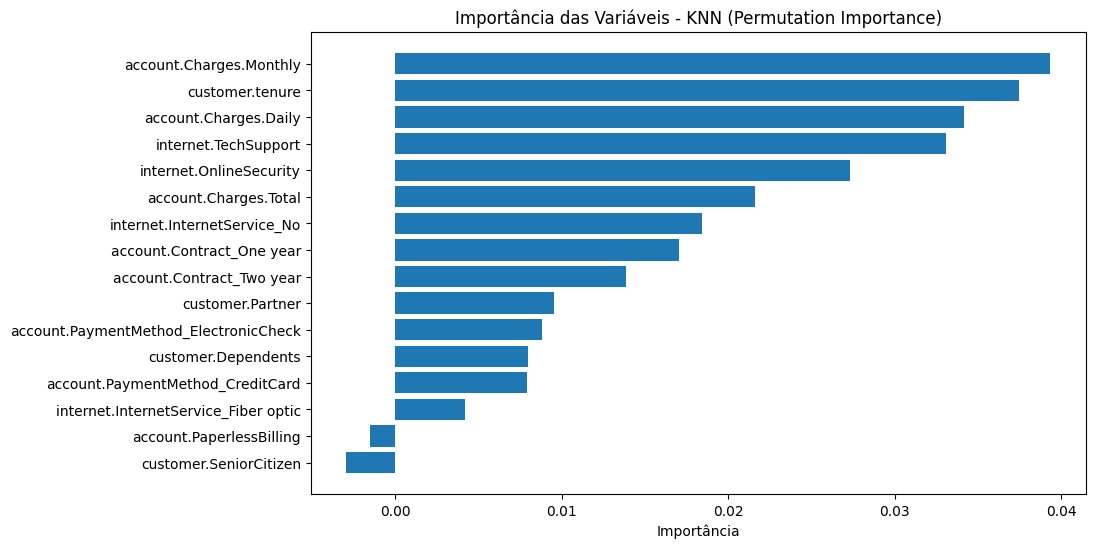

In [40]:
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

feat_imp_df = pd.DataFrame({'feature': X_test.columns, 'importance': result.importances_mean})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importância')
plt.title('Importância das Variáveis - KNN (Permutation Importance)')
plt.show()

#### Análise do gráfico
- Principais variáveis:
  - account.Charges.Monthly , customer.tenure e account.Charges.Daily são as variáveis com maior importância. Isso indica que o valor das cobranças mensais, o tempo de permanência do cliente e o valor diário são os fatores que mais afetam a proximidade entre os pontos e, consequentemente, a classificação do KNN.
- Serviços e suporte:
  - internet.TechSupport e internet.OnlineSecurity também aparecem como relevantes, mostrando que serviços adicionais influenciam o comportamento do cliente.
- Cobrança total e tipo de serviço:
  - account.Charges.Total e internet.InternetService_No têm impacto intermediário, indicando que o total pago e o tipo de serviço de internet também contribuem para a decisão do modelo.
- Menor importância:
  - Métodos de pagamento, dependentes, faturamento eletrônico e ser idoso ( customer.SeniorCitizen ) têm menor influência no modelo KNN.
#### Interpretação
- O modelo KNN, assim como o Random Forest, prioriza variáveis financeiras e de relacionamento para definir a proximidade entre os clientes.
- Serviços extras e características contratuais têm influência, mas em menor grau.
- Fatores demográficos e de pagamento são menos relevantes para o modelo.
Conclusão: Para o KNN, as variáveis que mais contribuem para a decisão são aquelas que afetam diretamente a distância entre os clientes, principalmente valores financeiros e tempo de relacionamento. Estratégias de retenção devem focar nesses fatores para maior impacto.

### 3. Redes Neurais

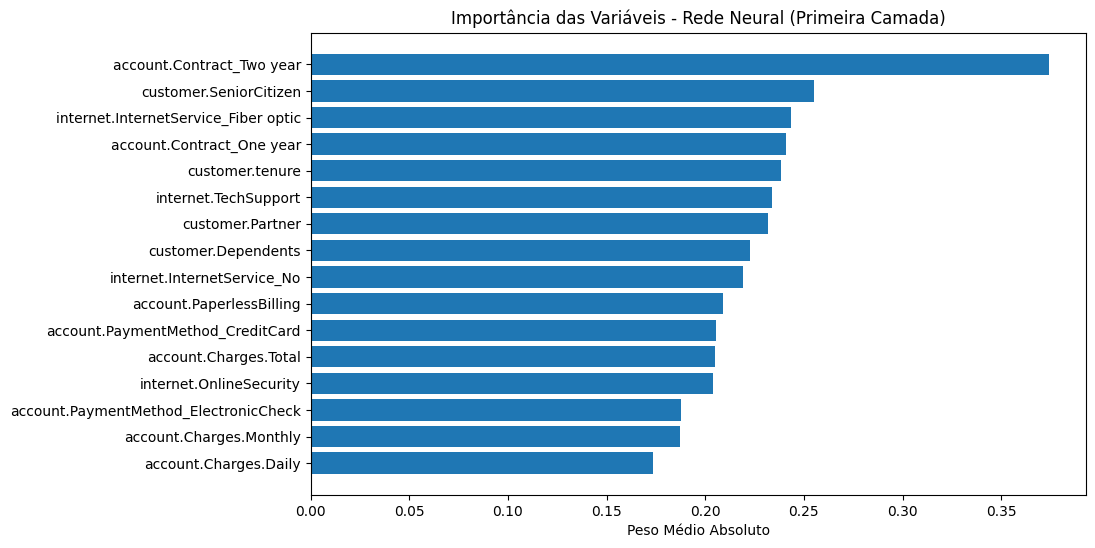

In [41]:
feature_names = X_train.columns

first_layer_weights = nn.layers[0].get_weights()[0]

mean_abs_weights = np.mean(np.abs(first_layer_weights), axis=1)

weights_df = pd.DataFrame({'feature': feature_names, 'mean_abs_weight': mean_abs_weights})
weights_df = weights_df.sort_values(by='mean_abs_weight', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(weights_df['feature'], weights_df['mean_abs_weight'])
plt.gca().invert_yaxis()
plt.xlabel('Peso Médio Absoluto')
plt.title('Importância das Variáveis - Rede Neural (Primeira Camada)')
plt.show()

#### Análise do gráfico
O gráfico apresenta a influência relativa das variáveis de entrada na ativação dos neurônios da primeira camada da rede neural, medida pelo peso médio absoluto atribuído a cada variável.
#### Principais Destaques
- Variáveis de Contrato ( account.Contract_Two year , account.Contract_One year ): São as mais influentes, indicando que o tipo e duração do contrato têm grande impacto na previsão de churn. Clientes com contratos mais longos tendem a apresentar padrões distintos de comportamento.
- Dependentes e Segurança Online ( customer.Dependents , internet.OnlineSecurity ): Também possuem alta relevância, sugerindo que fatores familiares e serviços de segurança influenciam fortemente a decisão de permanência ou saída do cliente.
- Serviços de Internet ( internet.InternetService_No , internet.InternetService_Fiber optic , internet.TechSupport ): A presença ou ausência de determinados serviços, bem como o suporte técnico, são importantes para o modelo.
- Fatores Demográficos ( customer.SeniorCitizen , customer.Partner ): Mostram influência moderada, indicando que características pessoais do cliente contribuem para a previsão, mas não são determinantes isolados.
- Variáveis Financeiras ( account.Charges.Daily , account.Charges.Total , account.Charges.Monthly ): Embora relevantes, aparecem abaixo das variáveis contratuais e de serviço, sugerindo que o valor cobrado é importante, mas não é o principal fator.
- Métodos de Pagamento ( account.PaymentMethod_CreditCard , account.PaymentMethod_ElectronicCheck , account.PaperlessBilling ): Têm menor influência, indicando que a forma de pagamento não é tão decisiva para o churn quanto outros fatores.
#### Interpretação Geral
O modelo de rede neural atribui maior importância a variáveis relacionadas ao tipo de contrato, dependentes e serviços de internet, o que está alinhado com o comportamento esperado de clientes em empresas de telecomunicações. Fatores financeiros e demográficos complementam a análise, mas não são os principais determinantes. Essa distribuição de pesos sugere que estratégias para retenção de clientes devem focar em ofertas contratuais e serviços agregados.

# Conclusão

## 1. Principais Fatores Identificados
A análise dos gráficos de importância das variáveis para os três modelos (Random Forest, KNN e Rede Neural) revela padrões consistentes sobre os fatores que mais influenciam a evasão (churn) de clientes:

### a) Variáveis Financeiras
- account.Charges.Monthly, account.Charges.Total, account.Charges.Daily : São as variáveis mais importantes nos modelos Random Forest e KNN. Isso indica que o valor cobrado mensalmente, o total acumulado e os gastos diários têm forte impacto na decisão do cliente de permanecer ou sair. Clientes com cobranças mais altas tendem a apresentar maior propensão à evasão.
### b) Tempo de Relacionamento
- customer.tenure : O tempo de permanência do cliente é altamente relevante, especialmente nos modelos Random Forest e KNN. Clientes mais antigos tendem a ser mais fiéis, enquanto novos clientes apresentam maior risco de evasão.
### c) Tipo e Duração do Contrato
- account.Contract_Two year, account.Contract_One year : Na Rede Neural, essas variáveis aparecem como as mais influentes. Contratos mais longos estão associados a menor evasão, pois oferecem maior estabilidade e benefícios ao cliente.
### d) Serviços de Internet e Suporte
- internet.TechSupport, internet.OnlineSecurity, internet.InternetService_Fiber optic, internet.InternetService_No : A presença de suporte técnico, segurança online e o tipo de serviço de internet impactam a satisfação do cliente. Falhas ou ausência desses serviços aumentam o risco de churn.
### e) Fatores Demográficos e de Pagamento
- customer.Dependents, customer.Partner, customer.SeniorCitizen, account.PaymentMethod_CreditCard, account.PaymentMethod_ElectronicCheck, account.PaperlessBilling : Embora menos relevantes, ainda contribuem para o modelo. Clientes com dependentes ou parceiros tendem a ser mais estáveis, enquanto métodos de pagamento e idade têm influência secundária.
## 2. Desempenho dos Modelos
- Random Forest : Destaca variáveis financeiras e tempo de relacionamento como principais fatores. É o modelo mais equilibrado na identificação dos fatores de churn.
- KNN : Apresenta padrão semelhante ao Random Forest, reforçando a importância dos valores cobrados e do tempo de cliente.
- Rede Neural : Dá maior peso ao tipo de contrato e dependentes, sugerindo que a estrutura contratual e fatores familiares são cruciais para retenção.
## 3. Estratégias de Retenção Propostas
Com base nos resultados obtidos, as seguintes estratégias podem ser adotadas:
- Revisão de Planos e Tarifas : Oferecer planos personalizados e descontos para clientes com cobranças elevadas pode reduzir a evasão.
- Fidelização de Novos Clientes : Investir em programas de boas-vindas e benefícios para clientes com pouco tempo de relacionamento aumenta a retenção.
- Promoção de Contratos Longos : Incentivar contratos de maior duração com vantagens exclusivas diminui o risco de churn.
- Melhoria dos Serviços de Internet e Suporte : Garantir suporte técnico eficiente e serviços de segurança online de qualidade é fundamental para a satisfação do cliente.
- Atenção a Perfis Específicos : Monitorar clientes com métodos de pagamento eletrônicos, idosos ou sem dependentes para identificar riscos e oferecer suporte direcionado.